References:
- https://github.com/JeongJiHeon/ScoreDiffusionModel/tree/main/NCSN
- https://github.com/KAIST-Visual-AI-Group/Diffusion-2025-Assignment1-DDPM-DDIM/blob/main/DDPM_DDIM.ipynb


In [1]:
import torch
print(torch.cuda.is_available())
!nvidia-smi

True
Mon Oct 20 12:26:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   57C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+

In [2]:
import io
import math
from ipywidgets import interact, IntSlider, Output
from IPython.display import display, clear_output
from PIL import Image
from typing import List, Optional

import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import KDTree
from scipy.spatial.distance import cdist
from sklearn import datasets
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
SEED = 1234         # WARNING: DO NOT CHANGE THE SEED

In [3]:
def seed_everything(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)

def normalize(ds, scaling_factor=2.0):
    return (ds - ds.mean()) / ds.std() * scaling_factor

def chamfer_distance(S1, S2) -> float:
    r"""
    Computes the Chamfer distance between two point clouds defined as:
    d_CD(S1, S2) = \sigma_{x \in S1} min_{y in S2} ||x - y||^2 + \sigma_{y \in S2} min_{x in S1} ||x - y||^2
    """
    dist = cdist(S1, S2)
    dist1 = dist.min(axis=1) ** 2
    dist2 = dist.min(axis=0) ** 2
    return dist1.sum() + dist2.sum()

def sample_checkerboard(n):
    # https://github.com/ghliu/SB-FBSDE/blob/main/data.py
    n_points = 3 * n
    n_classes = 2
    freq = 5
    x = np.random.uniform(
        -(freq // 2) * np.pi, (freq // 2) * np.pi, size=(n_points, n_classes)
    )
    mask = np.logical_or(
        np.logical_and(np.sin(x[:, 0]) > 0.0, np.sin(x[:, 1]) > 0.0),
        np.logical_and(np.sin(x[:, 0]) < 0.0, np.sin(x[:, 1]) < 0.0),
    )
    y = np.eye(n_classes)[1 * mask]
    x0 = x[:, 0] * y[:, 0]
    x1 = x[:, 1] * y[:, 0]
    sample = np.concatenate([x0[..., None], x1[..., None]], axis=-1)
    sqr = np.sum(np.square(sample), axis=-1)
    idxs = np.where(sqr == 0)
    sample = np.delete(sample, idxs, axis=0)

    return sample

def load_twodim(num_samples: int, dataset: str, dimension: int = 2):

    if dataset == "gaussian_centered":
        sample = np.random.normal(size=(num_samples, dimension))
        sample = sample*2 - 1

    if dataset == "gaussian_shift":
        sample = np.random.normal(size=(num_samples, dimension))
        sample = sample + 1.5

    if dataset == "circle":
        X, y = datasets.make_circles(
            n_samples=num_samples, noise=0.0, random_state=None, factor=0.5
        )
        sample = X * 4

    if dataset == "scurve":
        X, y = datasets.make_s_curve(
            n_samples=num_samples, noise=0.0, random_state=None
        )
        sample = normalize(X[:, [0, 2]])

    if dataset == "moon":
        X, y = datasets.make_moons(n_samples=num_samples, noise=0.0, random_state=None)
        sample = normalize(X)

    if dataset == "swiss_roll":
        X, y = datasets.make_swiss_roll(
            n_samples=num_samples, noise=0.0, random_state=None, hole=True
        )
        sample = normalize(X[:, [0, 2]])

    if dataset == "checkerboard":
        sample = normalize(sample_checkerboard(num_samples))

    return torch.tensor(sample).float()


class TwoDimDataClass(Dataset):
    def __init__(self, dataset_type: str, N: int, batch_size: int, dimension=2):

        self.X = load_twodim(N, dataset_type, dimension=dimension)
        self.name = dataset_type
        self.batch_size = batch_size
        self.dimension = 2

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx]

    def get_dataloader(self, shuffle=True):
        return DataLoader(
            self,
            batch_size=self.batch_size,
            shuffle=shuffle,
            pin_memory=True,
        )


def get_data_iterator(iterable):
    iterator = iterable.__iter__()
    while True:
        try:
            yield iterator.__next__()
        except StopIteration:
            iterator = iterable.__iter__()


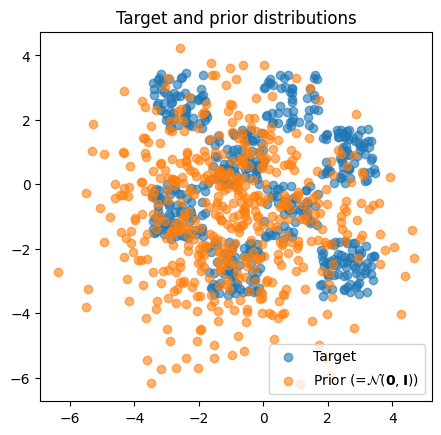

In [4]:
# Set seed
seed_everything(SEED)

target_ds = TwoDimDataClass(dataset_type='checkerboard',
                            N=1000000,
                            batch_size=256)

prior_ds = TwoDimDataClass(dataset_type='gaussian_centered',
                           N=1000000,
                           batch_size=256)

num_vis_particles = 500
sample_f = target_ds[0:num_vis_particles]
sample_b = prior_ds[0:num_vis_particles]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(sample_f[:, 0], sample_f[:, 1], alpha=0.6)
ax.scatter(sample_b[:, 0], sample_b[:, 1], alpha=0.6)
ax.grid(False)
ax.set_aspect('equal', adjustable='box')
strtitle = "Target and prior distributions"
ax.set_title(strtitle)
ax.legend(['Target', r'Prior (=$\mathcal{N}(\mathbf{0}, \mathbf{I})$)'])

In [10]:
class AnnealScoreMatching(nn.Module):
  def __init__(self, network, sigma_min, sigma_max, training_steps, eval_steps, eps):
    super().__init__()
    self.network = network
    self.sigmas = torch.exp(torch.linspace(start=math.log(sigma_max), end=math.log(sigma_min), steps = training_steps)).to(self.device)
    self.step_size = eps * (self.sigmas / self.sigmas[-1] ) ** 2
    self.annealed_step = eval_steps

  @property
  def device(self):
      return next(self.network.parameters()).device

  def compute_loss(self, x0):
    idx = torch.randint(0, len(self.sigmas), (x0.shape[0], )).to(self.device)
    used_sigma = self.sigmas[idx][:, None].to(self.device)
    noise = torch.randn_like(x0).to(self.device)
    x_noisy = x0.to(self.device) + noise * used_sigma

    target = -1 / used_sigma * noise

    score = self.network(x_noisy, idx)
    target = target.view(target.shape[0], -1)
    score = score.view(score.shape[0], -1)

    loss = torch.square(score - target).mean(dim=-1) * used_sigma.squeeze() ** 2

    return loss.mean(0)

  def annealed_langevin_dynamics(self, x):
    self.network.eval()
    for idx in range(len(self.sigmas)):
      for _ in range(self.annealed_step):
        z = torch.randn_like(x).to(self.device)
        step_size = self.step_size[idx]
        x = x + 0.5 * step_size * self.network(x, torch.tensor(idx).to(self.device)) + torch.sqrt(step_size) * z
    return x

  def sample(self, shape):
    sample = (torch.randn(shape).to(self.device) - 0.5)*2
    x = self.annealed_langevin_dynamics(sample)
    return x

In [11]:
device = torch.device("cuda")
lr = 5e-3
batch_size = 8192*2
num_train_iters = 5000

class SMModel(nn.Module):
  def __init__(self, n_steps):
    super().__init__()
    self.linear_model1 = nn.Sequential(
            nn.Linear(2, 256),
            nn.Dropout(0.3),
            nn.GELU()
        )
    self.embedding_layer = nn.Embedding(n_steps, 256)
    self.linear_model2 = nn.Sequential(
            nn.Linear(256, 512),
            nn.Dropout(0.3),
            nn.GELU(),
            nn.Linear(512, 512),
            nn.Dropout(0.3),
            nn.GELU(),
            nn.Linear(512, 2),
        )

  def forward(self, x, idx):
    out = self.linear_model1(x)
    embed = self.embedding_layer(idx)
    return self.linear_model2(out + embed)


def build_sm():
    eps = 1e-6
    sigma_min = 0.001
    sigma_max = 10
    n_steps = 10
    annealed_step = 100

    snet = SMModel(n_steps)
    sm = AnnealScoreMatching(snet.to(device), sigma_min, sigma_max, n_steps, annealed_step, eps)
    return sm

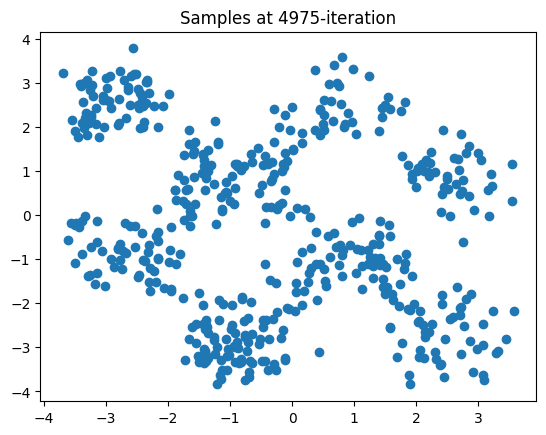

loss: 0.7587: 100%|██████████| 5000/5000 [07:03<00:00, 11.80it/s]


interactive(children=(IntSlider(value=1, description='index', max=25), Output()), _dom_classes=('widget-intera…

Output()

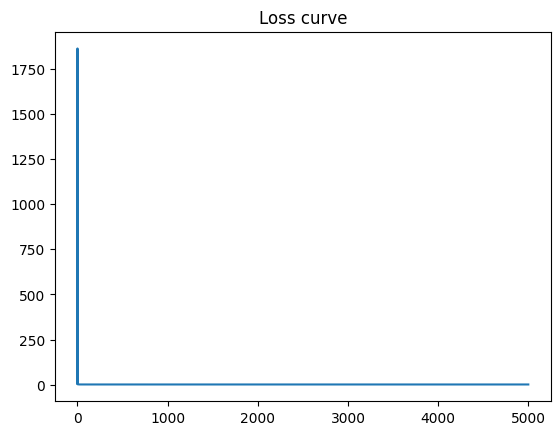

In [12]:
def figure2image(fig):
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img

# Set seed
seed_everything(SEED)

# Initialize the model.
sm = build_sm()

pbar = tqdm(range(num_train_iters))
optimizer = torch.optim.Adam(sm.parameters(), lr=lr)
train_dl = torch.utils.data.DataLoader(target_ds, batch_size=batch_size)
train_iter = get_data_iterator(train_dl)

losses = []
images = []
try:
    for step in pbar:
        optimizer.zero_grad()

        batch_x = next(train_iter)
        batch_x = batch_x.to(device)
        loss = sm.compute_loss(batch_x)

        loss.backward()
        optimizer.step()
        pbar.set_description(f"loss: {loss.item():.4f}")

        losses.append(loss.item())

        if step % 199 == 0:
            with torch.no_grad():
                x0 = sm.sample(shape=(num_vis_particles, 2)).cpu()

                fig, ax = plt.subplots(1,1)
                ax.scatter(x0[:,0], x0[:,1])
                ax.set_title(f"Samples at {step}-iteration")
                clear_output(wait=True)
                plt.show()
                img = figure2image(fig)
                images.append(img)

except KeyboardInterrupt:
    pass
finally:
    if len(images) > 0:
        slider = IntSlider(min=0, max=len(images)-1, step=1, value=1)
        output = Output()
        def display_image(index):
            with output:
                output.clear_output(wait=True)
                display(images[index])
        interact(display_image, index=slider)
        display(output)
        plt.plot(losses)
        plt.title("Loss curve")

In [21]:
torch.cuda.empty_cache()

Score Matching Chamfer Distance: 39.5326


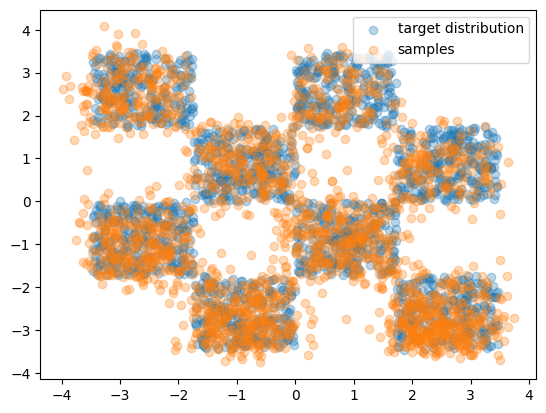

In [26]:
# Set seed
seed_everything(SEED)


num_eval_particles = 2048
pc_ref = target_ds[:num_eval_particles]
with torch.no_grad():
  pc_gen = sm.sample(shape=(num_eval_particles, 2))

pc_gen = pc_gen.reshape(num_eval_particles, 2).cpu().numpy()
pc_ref = pc_ref.reshape(num_eval_particles, 2).cpu().numpy()
with torch.no_grad():
    cd = chamfer_distance(
        pc_gen,
        pc_ref,
    )
    print(f"Score Matching Chamfer Distance: {cd.item():.4f}")

# Visualize samples with the target distribution.
fig, ax = plt.subplots(1,1)
ax.scatter(pc_ref[:,0], pc_ref[:,1], alpha=0.3, label="target distribution")
ax.scatter(pc_gen[:,0], pc_gen[:,1], alpha=0.3, label="samples")
ax.legend()
plt.show()

To-dos:
- Implement the 2D UNet
- Run on MNIST
- Read follow-up work on SDEs (https://arxiv.org/abs/2011.13456)
- (Hai's idea) Run on 3D data using PointNet as denoiser